In [1]:
import os 
import scipy.signal
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import xarray as xr
import time

import qcodes.instrument_drivers.rohde_schwarz.SGS100A as SGS100A
from pulsar_qrm.pulsar_qrm import pulsar_qrm
from pulsar_qcm.pulsar_qcm import pulsar_qcm

In [2]:
settings = {
        "waveform_qrm":{
            "shape": "Block",
            "gain": 0.5,
            "amplitude": 0.3,
            "freq_if": 20e6,  
            "length": 6000,
            "offset_i": -0,  
            "offset_q": -0,
        },
        "waveform_qcm_1":{
            "shape": "Gaussian",
            "gain": 0.5,
            "amplitude": 0.25,
            "freq_if": 100e6, 
            "length": 8000,
            "waveform_length_start": 50,
            "waveform_length_stop": 1000,
            "waveform_length_step": 50,
            "offset_i": 0,
            "offset_q": 0,

        },
        "integral_info":{
            "start_sample": 130,
            "hardware_avg": 1024,
            "integration_length": 6000,
            "sampling_rate": 1e9,
            "mode": "ssb"
        },
        "software_averages": 5,
        "hardware_avg": 1024,
    
}

### Instatiate Instruments

In [3]:
LO_qrm = SGS100A.RohdeSchwarz_SGS100A("qrm_LO", 'TCPIP0::192.168.0.7::inst0::INSTR')

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113301, firmware:4.2.76.0-4.30.046.295) in 0.08s


In [4]:
LO_qrm.power(10)
LO_qrm.frequency(7.79813e9-20e6)

LO_qcm = SGS100A.RohdeSchwarz_SGS100A("qcm_LO", 'TCPIP0::192.168.0.101::inst0::INSTR')
LO_qcm.power(12)
LO_qcm.frequency(8.72e9+100e6)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113300, firmware:4.2.76.0-4.30.046.295) in 0.03s


In [5]:
qrm = pulsar_qrm("qrm", "192.168.0.2")
qrm.reset()
qrm.reference_source("external")

qrm.sequencer0_gain_awg_path0(settings['waveform_qrm']['gain'])
qrm.sequencer0_gain_awg_path1(settings['waveform_qrm']['gain'])

#Enable hardware averaging
qrm.scope_acq_sequencer_select(0) 
qrm.scope_acq_avg_mode_en_path0(True)
qrm.scope_acq_avg_mode_en_path1(True)

qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

#Enable sequencer sync
qrm.sequencer0_sync_en(True)

In [6]:
qcm = pulsar_qcm("qcm", "192.168.0.3")
qcm.reset()
qcm.reference_source("external")

qcm.sequencer0_gain_awg_path0(settings['waveform_qcm_1']['gain'])
qcm.sequencer0_gain_awg_path1(settings['waveform_qcm_1']['gain'])
#Enable sequencer sync
qcm.sequencer0_sync_en(True)

In [7]:
# qrm.set_data_dictionary()

### Prepare readout and qubit control pulse waveforms

In [8]:
#"gain": 0.5,

def prepare_waveforms(freq_if, amplitude, length, offset_i, offset_q, shape= "Block"):
    
    if shape == 'Block':
        envelope_i = amplitude*np.ones(int(length))
        envelope_q = amplitude*np.zeros(int(length))
    elif shape == 'Gaussian':
        std = length/5
        envelope_i = amplitude*scipy.signal.gaussian(length, std=std)
        envelope_q = amplitude*np.zeros(int(length))

    time = np.arange(length)*1e-9
    cosalpha = np.cos(2*np.pi*freq_if*time)
    sinalpha = np.sin(2*np.pi*freq_if*time)
    mod_matrix = np.array([[cosalpha,sinalpha],[-sinalpha,cosalpha]])
    result = []
    for it,t,ii,qq in zip(np.arange(length),time,envelope_i,envelope_q):
        result.append(mod_matrix[:,:,it]@np.array([ii,qq]))
    mod_signals = np.array(result)

    waveforms = {
            "modI_qrm": {"data": [], "index": 0},
            "modQ_qrm": {"data": [], "index": 1}
        }
    # adding mixer offsets
    waveforms["modI_qrm"]["data"] = mod_signals[:,0]+offset_i
    waveforms["modQ_qrm"]["data"] = mod_signals[:,1]+offset_q

    fig, ax = plt.subplots(1, 1, figsize=(15, 15/2/1.61))
    ax.plot(waveforms["modI_qrm"]["data"],'-',color='C0')
    ax.plot(waveforms["modQ_qrm"]["data"],'-',color='C1')
    ax.title.set_text('QRM output')
    return waveforms

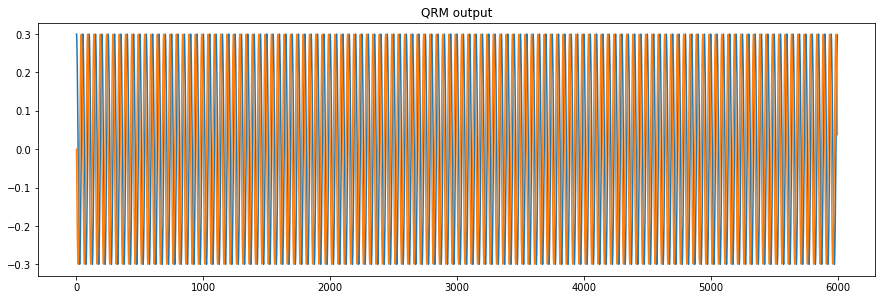

In [9]:
qrm_waveforms=prepare_waveforms(freq_if = settings["waveform_qrm"]["freq_if"], amplitude = settings["waveform_qrm"]["amplitude"], length = settings["waveform_qrm"]["length"], 
                                offset_i = settings["waveform_qrm"]["offset_i"], offset_q = settings["waveform_qrm"]["offset_q"], shape= settings["waveform_qrm"]["shape"])

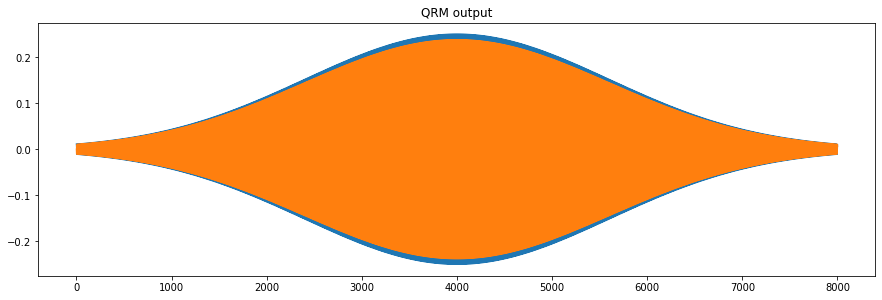

In [10]:
qcm_waveforms=prepare_waveforms(freq_if = settings["waveform_qcm_1"]["freq_if"], amplitude = settings["waveform_qcm_1"]["amplitude"], length = settings["waveform_qcm_1"]["length"], 
                                offset_i = settings["waveform_qcm_1"]["offset_i"], offset_q = settings["waveform_qcm_1"]["offset_q"], shape= settings["waveform_qcm_1"]["shape"])

### Prepare readout and qubit control sequence programs

In [11]:
def calculate_repetition_rate(repetition_duration,
                              wait_loop_step,
                              duration_base):
    extra_duration = repetition_duration-duration_base
    extra_wait = extra_duration%wait_loop_step
    num_wait_loops = (extra_duration-extra_wait)//wait_loop_step
    return num_wait_loops,extra_wait

In [12]:
acquisitions = {"single":   {"num_bins": 1,"index":0}}

repetition_duration= 200000
wait_loop_step=1000
duration_base=16380

buffer_time = 40  #ns
num_wait_loops,extra_wait = calculate_repetition_rate(repetition_duration, wait_loop_step, duration_base)
length = settings["waveform_qcm_1"]["length"]

qrm_seq_prog = f"""
    move    {settings["hardware_avg"]},R0
    nop
    wait_sync 4          # Synchronize sequencers over multiple instruments

loop:
    wait      {length+buffer_time}       # idle for xx ns gaussian pulse + 40 ns buffer
    play      0,1,4      # Play waveforms (0,1) in channels (O0,O1) and wait 4ns.
    acquire   0,0,4      # Acquire waveforms over remaining duration of acquisition of input vector of length = 16380 with integration weights 0,0
    wait      {duration_base-4-length-buffer_time}
    move      {num_wait_loops},R1     # repetion rate loop iterator
    nop
    reprateloop:
        wait      {wait_loop_step}
        loop      R1,@reprateloop
    wait      {extra_wait}
    loop    R0,@loop

    stop
"""

print(qrm_seq_prog)


    move    1024,R0
    nop
    wait_sync 4          # Synchronize sequencers over multiple instruments

loop:
    wait      8040       # idle for xx ns gaussian pulse + 40 ns buffer
    play      0,1,4      # Play waveforms (0,1) in channels (O0,O1) and wait 4ns.
    acquire   0,0,4      # Acquire waveforms over remaining duration of acquisition of input vector of length = 16380 with integration weights 0,0
    wait      8336
    move      183,R1     # repetion rate loop iterator
    nop
    reprateloop:
        wait      1000
        loop      R1,@reprateloop
    wait      620
    loop    R0,@loop

    stop



In [13]:

qcm_seq_prog = f"""
    move    {settings["hardware_avg"]},R0
    nop
    wait_sync 4           # Synchronize sequencers over multiple instruments

loop:
    play      0,1,4   # Play waveforms (0,1) and wait remaining duration of scope acquisition.
    wait      {duration_base}
    move      {num_wait_loops},R1      # repetion rate loop iterator
    nop
    reprateloop:
        wait      {wait_loop_step}
        loop      R1,@reprateloop
    wait      {extra_wait}
    loop      R0,@loop

    stop
"""

print(qcm_seq_prog)


    move    1024,R0
    nop
    wait_sync 4           # Synchronize sequencers over multiple instruments

loop:
    play      0,1,4   # Play waveforms (0,1) and wait remaining duration of scope acquisition.
    wait      16380
    move      183,R1      # repetion rate loop iterator
    nop
    reprateloop:
        wait      1000
        loop      R1,@reprateloop
    wait      620
    loop      R0,@loop

    stop



### Upload waveforms

In [14]:
# Reformat waveforms to lists.
for name in qrm_waveforms:
    if str(type(qrm_waveforms[name]["data"]).__name__) == "ndarray":
        qrm_waveforms[name]["data"] = qrm_waveforms[name]["data"].tolist()  # JSON only supports lists

In [15]:
#Add sequence program and waveforms to single dictionary and write to JSON file.
qrm_wave_and_prog_dict = {"waveforms": qrm_waveforms, "weights":{}, "acquisitions": acquisitions, "program": qrm_seq_prog}
with open("qrm_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(qrm_wave_and_prog_dict, file, indent=4)
    file.close()

In [16]:
#Upload waveforms and program.
qrm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qrm_sequence.json"))

In [17]:
# Reformat waveforms to lists.
for name in qcm_waveforms:
    if str(type(qcm_waveforms[name]["data"]).__name__) == "ndarray":
        qcm_waveforms[name]["data"] = qcm_waveforms[name]["data"].tolist()  # JSON only supports lists

In [18]:
#Add sequence program and waveforms to single dictionary and write to JSON file.
qcm_wave_and_prog_dict = {"waveforms": qcm_waveforms, "weights":{}, "acquisitions": acquisitions, "program": qcm_seq_prog}
with open("qcm_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(qcm_wave_and_prog_dict, file, indent=4)
    file.close()  

In [19]:
#Upload waveforms and program.
qcm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qcm_sequence.json"))

In [20]:
#print(qrm._get_sequencer_config(0))
#print(qcm._get_sequencer_config(0))
#Print status of sequencers.
print("QCM status:")
print(qcm.get_sequencer_state(0))
print()

print("QRM status:")
print(qrm.get_sequencer_state(0))
print()

#Print an overview of instrument parameters.
print("QCM snapshot:")
qcm.print_readable_snapshot(update=True)
print()

print("QRM snapshot:")
qrm.print_readable_snapshot(update=True)

QCM status:
{'status': 'STOPPED', 'flags': []}

QRM status:
{'status': 'STOPPED', 'flags': ['ACQ BINNING DONE']}

QCM snapshot:
qcm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
reference_source                            :	external 
sequencer0_cont_mode_en_awg_path0           :	False 
sequencer0_cont_mode_en_awg_path1           :	False 
sequencer0_cont_mode_waveform_idx_awg_path0 :	0 
sequencer0_cont_mode_waveform_idx_awg_path1 :	0 
sequencer0_gain_awg_path0                   :	0.49998 
sequencer0_gain_awg_path1                   :	0.49998 
sequencer0_marker_ovr_en                    :	False 
sequencer0_marker_ovr_value                 :	0 
sequencer0_mod_en_awg                       :	False 
sequencer0_nco_freq                         :	0 (Hz)
sequencer0_nco_phase_offs                   :	0 (Degrees)
sequencer0_offset_a

## Send pulses

In [21]:
LO_qcm.on()
LO_qrm.on()

for n in range(10):
    #Arm sequencers.
    qcm.arm_sequencer()
    qrm.arm_sequencer()

    #Start sdequencers.
    #qcm.start_sequencer()
    qrm.start_sequencer()
    
    time.sleep(1)

LO_qcm.off()
LO_qrm.off()



In [22]:
#Print status of the QRM (only sequencer 0)
print("QRM status:")
print(qrm.get_sequencer_state(0))
print(qrm.get_system_status())
# Print status of the QRM (only sequencer 0)
print("QCM status:")
print(qcm.get_sequencer_state(0))
print(qcm.get_system_status())

QRM status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE OVERWRITTEN PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ SCOPE OVERWRITTEN PATH 1', 'ACQ BINNING DONE']}
{'status': 'OKAY', 'flags': []}
QCM status:
{'status': 'ARMED', 'flags': []}
{'status': 'OKAY', 'flags': []}


In [ ]:
#IQSignal_qubit_freq_spec(info,qrm,qcm)